In [39]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import os,shutil
from lda_model import *
from sklearn.metrics import f1_score,accuracy_score,precision_recall_fscore_support,balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
import wordcloud

In [41]:
data=pd.read_csv("get_data/tweets - concenso.csv").dropna(subset=['seguridad'])

In [42]:
colum_text='texto'
colum_label="seguridad"

new_values=[]

functions=[remove_RT,remove_url,replace_tags,remove_arroba,remove_emoji,remove_stopwords]
for i in data[colum_text].values:
    text=i
    for j in functions:
        text=j(text)
    new_values.append(text)
    
new_values_join=[]
for i in new_values:
    new_values_join.append(" ".join(i))
data["CleanText"]=new_values_join
colum_text='CleanText'
data=data.drop_duplicates(subset='CleanText').reset_index(drop=True)
data.to_csv("get_data/clasificador_seguridad/tweets_concenso.csv",index=False)

In [43]:
len(data)

1231

In [44]:
# para convertir una base de datos a formato que interpreta
# fasttext, una fila por registro con la etiqueta marcada
# con __label__x seguido por el texto 
def csv_to_text(data_frame,colum_label,colum_text,final_name):
    data=data_frame.copy()
    lines=[]
    for i,j in zip(data[colum_label].values,data[colum_text].values):
        lines.append("__label__"+str(int(i))+" "+j)
    with open(final_name, 'w') as fo:
        for idx, item in enumerate(lines):
            if idx:  
                fo.write('\n')
            fo.write(item)

    return final_name

def predict(model,data_new,percent=True):
    A,B=model.predict(data_new,k=2)
    percents=[]
    for a,b in zip(A,B):
        Z = [x for _,x in sorted(zip(a,b))]
        percents.append(Z)
    percents=pd.DataFrame(percents)
    if percent==True:
        return percents
    else:
        return percents.idxmax(axis=1).values
    

In [45]:
test=data.sample(int(len(data)*0.3))
train=data.drop(test.index)

In [46]:
test.seguridad.mean(),train.seguridad.mean()

(0.34417344173441733, 0.3352668213457077)

In [47]:
data.seguridad.mean()

0.3379366368805849

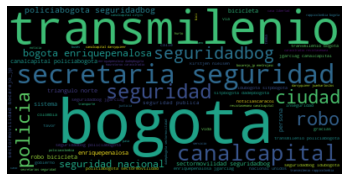

In [48]:
Wordcloud = wordcloud.WordCloud().generate(" ".join(data.CleanText.values))
plt.imshow(Wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("test/wc_seguridad_00.png",bbox_inches='tight')
plt.show()

In [49]:
train_path=csv_to_text(train,"seguridad","CleanText","get_data/clasificador_seguridad/split_data/train__00.txt")
test_path=csv_to_text(test,"seguridad","CleanText","get_data/clasificador_seguridad/split_data/test__00.txt")

In [50]:
import fasttext

In [52]:
model = fasttext.train_supervised(  input=train_path,             # training file path (required)
                                        lr=1,                # learning rate [0.1]
                                        dim=300,               # size of word vectors [100]
                                        ws=2,                # size of the context window [5]
                                        epoch=5,             # number of epochs [5]
                                        minCount=3,          # minimal number of word occurences [1]
                                        minCountLabel=1,     # minimal number of label occurences [1]
                                        minn=0,              # min length of char ngram [0]
                                        maxn=1,              # max length of char ngram [0]
                                        neg=5,               # number of negatives sampled [5]
                                        wordNgrams=2,        # max length of word ngram [1]
                                        loss='softmax',              # loss function {ns, hs, softmax, ova} [softmax]
                                        bucket=2000000,            # number of buckets [2000000]
                                        lrUpdateRate=100,      # change the rate of updates for the learning rate [100]
                                        t=0.0001,                 # sampling threshold [0.0001]
                                        label="__label__",             # label prefix ['__label__']
                                        verbose=2,           # verbose [2]
                                        pretrainedVectors="fasttext/wiki.es.vec"
                                     )

In [37]:
model.quantize(input=train_path, retrain=False)

In [38]:
model.save_model("get_data/clasificador_seguridad/split_data/model.ftz")

In [18]:
f1_train=f1_score(train.seguridad,predict(model,list(train.CleanText),percent=False))
f1_train

1.0

In [19]:
f1_test=f1_score(test.seguridad,predict(model,list(test.CleanText),percent=False))
f1_test

0.6909090909090908

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          f1=0,
                          title='Matriz de Confusión',
                          path_save="",
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = f1
    

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nf1_score={:0.4f}'.format(accuracy))
    plt.savefig(path_save,bbox_inches='tight')
    plt.show()

from sklearn.metrics import confusion_matrix

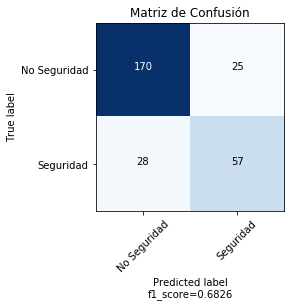

In [19]:
plot_confusion_matrix(confusion_matrix(test.seguridad,predict(model,list(test.CleanText),percent=False)),
                      ['No Seguridad','Seguridad'],f1_test,path_save="test/confusion_matrix_test.png",
                      normalize=False
                     )

In [20]:
new_validacion=pd.read_csv("get_data/new_validation.csv")

In [21]:
colum_text='full_text'
colum_label="seguridad"

new_values=[]

functions=[remove_RT,remove_url,replace_tags,remove_arroba,remove_emoji,remove_stopwords]
for i in new_validacion[colum_text].values:
    text=i
    for j in functions:
        text=j(text)
    new_values.append(text)
    
new_values_join=[]
for i in new_values:
    new_values_join.append(" ".join(i))
new_validacion["CleanText"]=new_values_join

In [22]:
new_validacion.seguridad.mean()

0.02

In [23]:
new_validacion

,seguridad,full_text,CleanText
0,0,"Acaba de publicar una foto en Bogotá, Colombia https://t.co/UpCz3bqdOE",acaba publicar foto bogota colombia
1,0,Ufff men me vi en el 2004 jajajaja 👴🏻 https://t.co/btExiP2lDr,ufff men vi jajajaja
2,0,Que gonorrea ser tan inseguraa,gonorrea inseguraa
3,0,@Portafolioco Es porque ya llegado la era de otra revolución industrial: la tecnológica.,portafolioco llegado revolucion industrial tecnologica
4,1,Autoridades incrementaron la seguridad para la Feria de Manizales https://t.co/aaHF83f2ND https://t.co/15ZHfbBepv,autoridades incrementaron seguridad feria manizales
...,...,...,...
995,0,@BID_Seguridad Estos son los rincones del mundo donde los niños pasan hambre https://t.co/1uK74mI2k9 a través de @Planeta_Futuro,bid_seguridad rincones mundo ninos pasan hambre planeta_futuro
996,0,A las 9 de la mañana cuando salíamos temprano del colegio😂 https://t.co/XNTLaw5S5c,manana saliamos colegio
997,0,Mis amados de la obra Orquídeas Bogotá-Colombia. https://t.co/QmN6uuTlCu,amados obra orquideas bogota colombia
998,0,"@Lynx_581 No aguanta comparar a Fredy que fue Arte de verdad, música, letra y mensaje para inteligentes.",lynx_ aguanta comparar fredy arte musica letra mensaje inteligentes


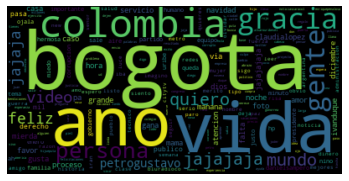

In [24]:
Wordcloud = wordcloud.WordCloud().generate(" ".join(new_validacion.CleanText.values))
plt.imshow(Wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("test/wc_new_val.png",bbox_inches='tight')
plt.show()

In [25]:
f1_new=f1_score(new_validacion.seguridad,
         predict(model,list(new_validacion.CleanText),percent=False))
f1_new

0.07692307692307693

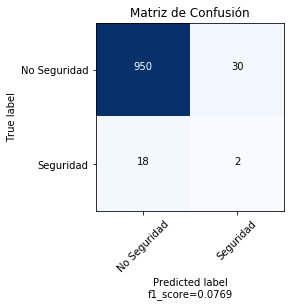

In [26]:
plot_confusion_matrix(confusion_matrix(new_validacion.seguridad,predict(model,list(new_validacion.CleanText),percent=False)),
                      ['No Seguridad','Seguridad'],f1_new,path_save="test/confusion_matrix_new_validacion.png",
                      normalize=False
                     )

In [27]:
new_validacion_train=new_validacion.sample(500)
new_validacion_test=new_validacion.drop(new_validacion_train.index)
new_validacion_train.rename(columns={'full_text':'texto'},inplace=True)
new_validacion_test.rename(columns={'full_text':'texto'},inplace=True)

In [28]:
new_validacion_train.seguridad.mean(),new_validacion_test.seguridad.mean()

(0.02, 0.02)

In [29]:
results=[]

In [156]:
results.append([f1_score(new_validacion_test.seguridad,
         predict(model,list(new_validacion_test.CleanText),percent=False)),
                f1_score(test.seguridad,
         predict(model,list(test.CleanText),percent=False))

               ])

/u01/user8/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [157]:
results

[[0.06896551724137931, 0.6826347305389221],
 [0.23529411764705882, 0.6748466257668712],
 [0.18181818181818182, 0.6625],
 [0.26666666666666666, 0.6583850931677019],
 [0.14285714285714288, 0.6708074534161491],
 [0.14285714285714288, 0.6540880503144655],
 [0.14285714285714288, 0.6496815286624203],
 [0.14285714285714288, 0.6455696202531646],
 [0.0, 0.6282051282051282],
 [0.0, 0.6496815286624203],
 [0.18181818181818182, 0.6451612903225806],
 [0.0, 0.632258064516129]]

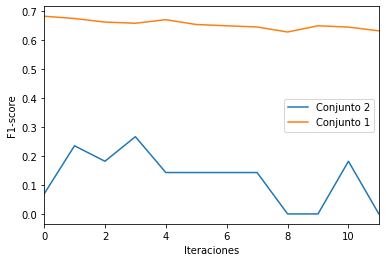

In [158]:
fig=pd.DataFrame(results,columns=['Conjunto 2','Conjunto 1']).plot()
fig.set_xlabel("Iteraciones")
fig.set_ylabel("F1-score")
fig_ = fig.get_figure()
fig_.savefig("test/f1_iter.png",bbox_inches='tight')

In [148]:
new_validacion_train["to_oracle"]=(predict(model,list(new_validacion_train['CleanText'].values)).max(axis=1) < 0.8).values

In [149]:
new_validacion_train.to_oracle.sum()

0

In [150]:
len(new_validacion_train)

0

In [151]:
#index_to_oracle=new_validacion_train[new_validacion_train.to_oracle == True].sample(frac=1).head(10).index

In [152]:
index_to_oracle=new_validacion_train.sample(frac=1).head(50).index

In [153]:
data_to_merge=new_validacion_train.loc[index_to_oracle].drop("to_oracle",axis=1)
new_validacion_train.drop(index_to_oracle,axis=0,inplace=True)
train=pd.concat([train,data_to_merge])

In [154]:
train_path=csv_to_text(train,"seguridad","CleanText","get_data/clasificador_seguridad/split_data/train_0.txt")

In [155]:
model = fasttext.train_supervised(  input=train_path,             # training file path (required)
                                        lr=1,                # learning rate [0.1]
                                        dim=300,               # size of word vectors [100]
                                        ws=2,                # size of the context window [5]
                                        epoch=5,             # number of epochs [5]
                                        minCount=3,          # minimal number of word occurences [1]
                                        minCountLabel=1,     # minimal number of label occurences [1]
                                        minn=0,              # min length of char ngram [0]
                                        maxn=1,              # max length of char ngram [0]
                                        neg=5,               # number of negatives sampled [5]
                                        wordNgrams=2,        # max length of word ngram [1]
                                        loss='softmax',              # loss function {ns, hs, softmax, ova} [softmax]
                                        bucket=2000000,            # number of buckets [2000000]
                                        lrUpdateRate=100,      # change the rate of updates for the learning rate [100]
                                        t=0.0001,                 # sampling threshold [0.0001]
                                        label="__label__",             # label prefix ['__label__']
                                        verbose=2,           # verbose [2]
                                        pretrainedVectors="fasttext/wiki.es.vec"
                                     )